In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process

In [2]:
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

In [3]:
file_path = 'synthetic_housing_data_10k.csv'
df = pd.read_csv(file_path)

df_cleaned = remove_outliers(df, 'square_footage')
df_cleaned = remove_outliers(df_cleaned, 'num_bedrooms')
df_cleaned = remove_outliers(df_cleaned, 'price')

print(df_cleaned.head())

   square_footage  num_bedrooms location   price
0            1660             1   Austin  265590
1            2094             1   Boston  341992
2            1930             2  Chicago  357240
3            1895             3   Boston  429978
4            2438             2   Boston  427488


In [4]:
X = df_cleaned[['square_footage', 'num_bedrooms', 'location']]
y = df_cleaned['price']

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['square_footage', 'num_bedrooms']),
        ('cat', OneHotEncoder(), ['location'])
    ])
pipeline = Pipeline(steps=[('preprocessor',preprocessor),('model',LinearRegression())])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['square_footage',
                                                   'num_bedrooms']),
                                                 ('cat', OneHotEncoder(),
                                                  ['location'])])),
                ('model', LinearRegression())])

In [8]:
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared value: {r2}")

Mean Squared Error: 842957288.011532
R-squared value: 0.9340657154176418


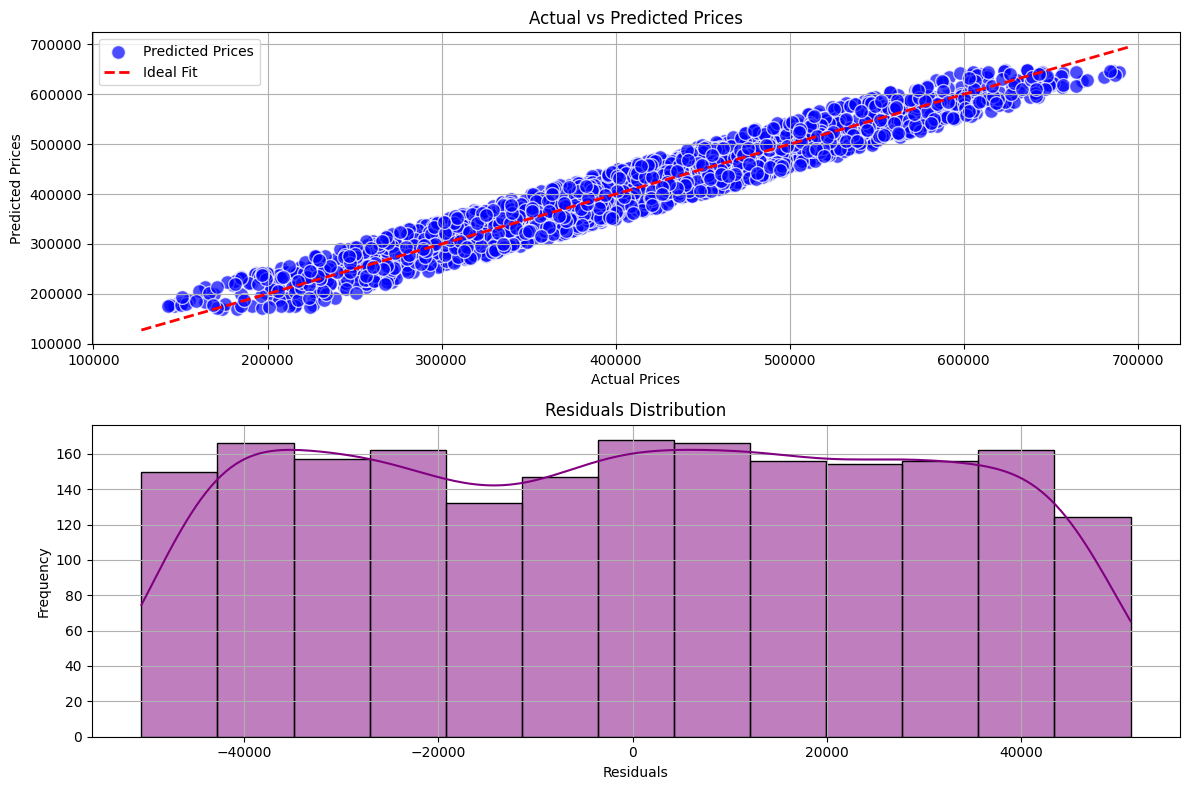

In [9]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, edgecolors='w', s=100, label='Predicted Prices')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.grid(True)

residuals = y_test - y_pred
plt.subplot(2, 1, 2)
sns.histplot(residuals, kde=True, color='purple')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
predictions_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_pred
}).reset_index(drop=True)

print(predictions_df.head())

   Actual Price  Predicted Price
0        459934    476494.377591
1        459795    474742.506606
2        590145    591933.740185
3        180184    217494.129758
4        607098    563060.652385


In [11]:
def correct_location(input_location, valid_locations):
    input_location = input_location.lower().strip()
    closest_match = process.extractOne(input_location, valid_locations, score_cutoff=80)
    if closest_match:
        return closest_match[0]
    else:
        return None

In [12]:
def predict_price(square_footage, num_bedrooms, location):
    valid_locations = df_cleaned['location'].unique()
    corrected_location = correct_location(location, valid_locations)
    
    if corrected_location is None:
        return "Location not recognized. Please check your input."

    input_data = pd.DataFrame([[square_footage, num_bedrooms, corrected_location]],
                              columns=['square_footage', 'num_bedrooms', 'location'])
    
    prediction = pipeline.predict(input_data)[0]
    return prediction

In [13]:
if __name__ == "__main__":
    try:
        sq_footage = float(input("Enter square footage: ").strip())
        bedrooms = int(input("Enter number of bedrooms: ").strip())
        loc = input("Enter location: ").strip()
        
        predicted_price = predict_price(sq_footage, bedrooms, loc)
        
        if isinstance(predicted_price, str):
            print(predicted_price)
        else:
            print(f"The predicted price is: ${predicted_price:,.2f}")
    except ValueError:
        print("Please enter valid numeric values for square footage and number of bedrooms.")

The predicted price is: $149,621.04
